cuda:0


/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/comp/yangliu

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


cuda:0


Epoch Loss:203.475: 100%|██████████| 400/400 [01:28<00:00,  4.53it/s]


fitting ...
  |======================================================================| 100%


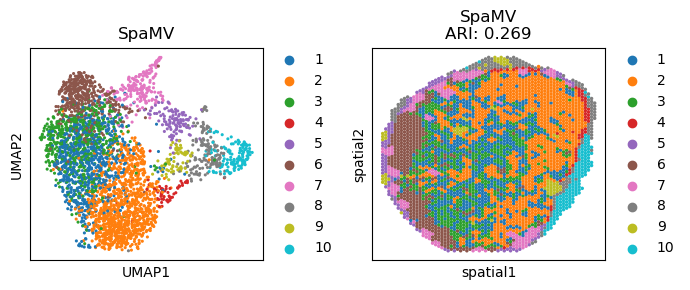

In [4]:
import random

import anndata
import pandas
import torch
import sys
import os
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_rand_score

# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(current_dir))
from Methods.SpaMV.spamv import SpaMV
from Methods.SpaMV.utils import pca, clr_normalize_each_cell, ST_preprocess, clustering
import scanpy as sc
import wandb

dataset = '9_Mouse_Thymus'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
max_epochs = 400
data_omics1 = sc.read_h5ad('../Dataset/' + dataset + '/adata_RNA.h5ad')
data_omics1 = ST_preprocess(data_omics1)
data_omics1 = anndata.AnnData(pca(data_omics1, n_comps=18), obs=data_omics1.obs, obsm=data_omics1.obsm)
data_omics1.obsm['X_pca'] = data_omics1.X

data_omics2 = sc.read_h5ad('../Dataset/' + dataset + '/adata_ADT.h5ad')
data_omics2 = data_omics2[data_omics1.obs_names, :]
data_omics2 = clr_normalize_each_cell(data_omics2)
sc.pp.scale(data_omics2)
data_omics2 = anndata.AnnData(pca(data_omics2, n_comps=18), obs=data_omics2.obs, obsm=data_omics2.obsm)
data_omics2.obsm['X_pca'] = data_omics2.X
omics_names = ['Transcriptomics', 'Proteomics']

wandb.init(project=dataset)
wandb.login()
model = SpaMV([data_omics1, data_omics2], betas=[1, 1], interpretable=False, dropout_prob=0, learning_rate=1e-3, min_kl=1, max_kl=1,
                neighborhood_embedding=10, recon_types=['gauss', 'gauss'], omics_names=omics_names,
                max_epochs=max_epochs, test_mode=False, device=device)
model.train(dataset)
wandb.finish()
data_omics1.obsm['SpaMV'] = model.get_embedding()
clustering(data_omics1, key='SpaMV', add_key='SpaMV', n_clusters=10, method='mclust', use_pca=True)
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
sc.pp.neighbors(data_omics1, use_rep='SpaMV', n_neighbors=10)
sc.tl.umap(data_omics1)
sc.pl.umap(data_omics1, color='SpaMV', ax=axes[0], s=20, show=False)
sc.pl.embedding(data_omics1, color='SpaMV', basis='spatial', ax=axes[1], s=25, show=False)
plt.tight_layout()
plt.savefig('../Results/' + dataset + '/SpaMV.pdf')
data_omics1.write_h5ad('../Results/' + dataset + '/SpaMV.h5ad')

cuda:0


/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:171: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


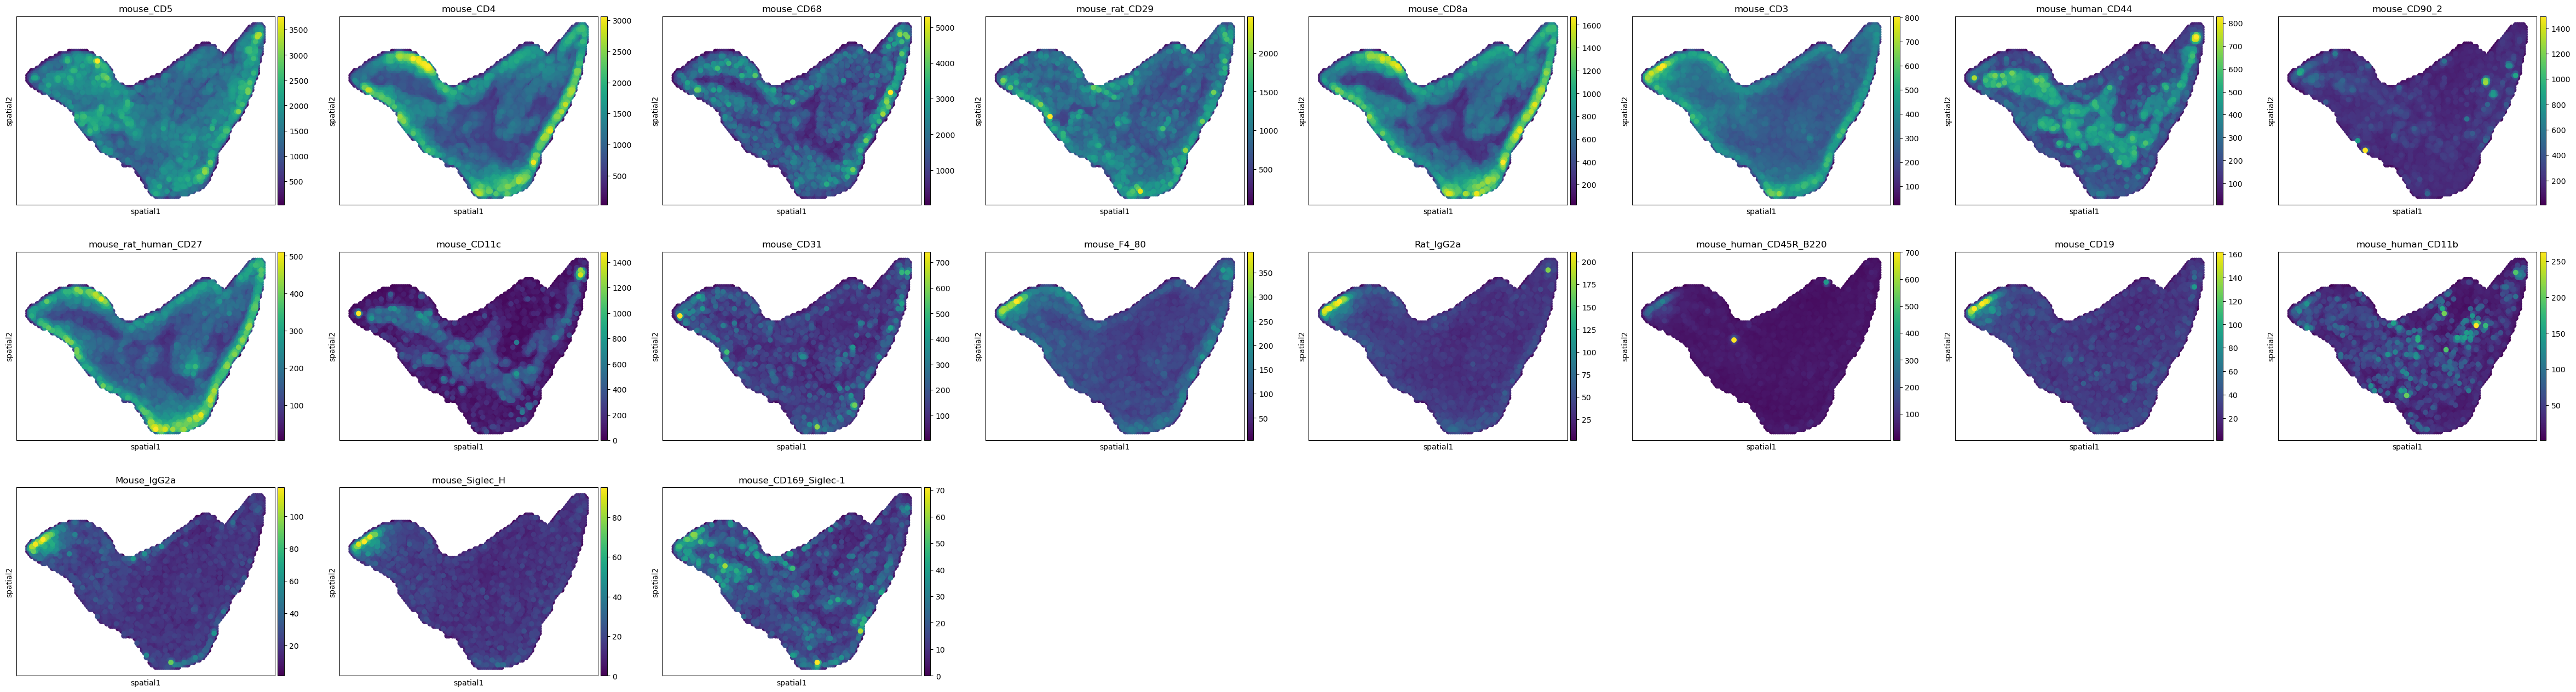

/home/comp/yangliu1214/Formal/Methods/SpaMV/utils.py:278: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = np.apply_along_axis(


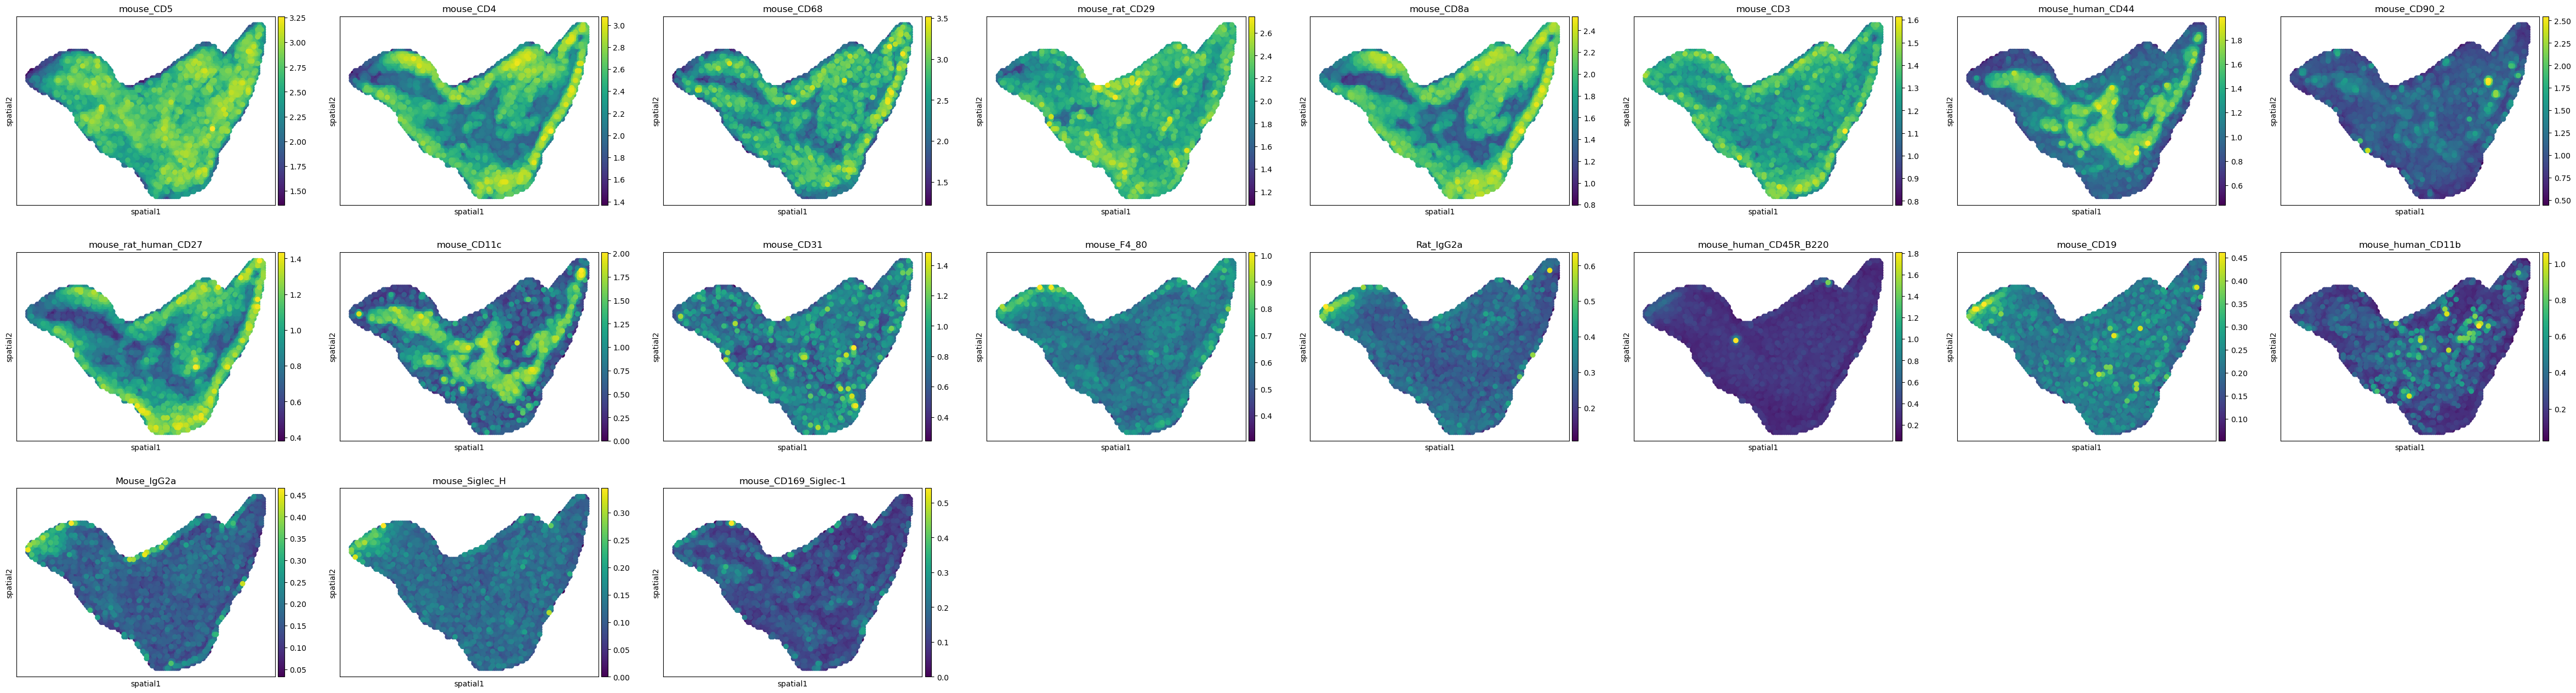

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


cuda:0


In [ ]:
import random

import pandas
import torch
import sys
import os
import numpy as np

from matplotlib import pyplot as plt
from pandas import DataFrame
from scanpy.plotting import embedding

def softmax(row):
    shifted = row - np.max(row)  # Prevent overflow
    exp_values = np.exp(shifted)
    return exp_values / exp_values.sum()

# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(current_dir))
from Methods.SpaMV.spamv import SpaMV
from Methods.SpaMV.utils import plot_embedding_results, clr_normalize_each_cell
from Methods.SpaMV.metrics import compute_topic_coherence, compute_topic_diversity
import scanpy as sc
import wandb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

dataset = '9_Mouse_Thymus'
data_folder = '../Dataset/' + dataset
omics_names = ['Transcriptomics', "Proteomics"]
recon_types = ['nb', 'nb']

adata_rna = sc.read_h5ad(data_folder + '/adata_RNA.h5ad')
adata_pro = sc.read_h5ad(data_folder + '/adata_ADT.h5ad')
sc.pp.filter_cells(adata_rna, min_genes=200)
sc.pp.filter_cells(adata_pro, min_genes=1)
adata_rna = adata_rna[adata_rna.obs_names.intersection(adata_pro.obs_names)]
adata_pro = adata_pro[adata_rna.obs_names]

sc.pp.filter_genes(adata_rna, min_cells=10)
adata_rna = adata_rna[:, (adata_rna.X > 1).sum(0) > adata_rna.n_obs / 100]
sc.pp.highly_variable_genes(adata_rna, subset=False, n_top_genes=1000, flavor='seurat_v3')
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
adata_rna = adata_rna[:, adata_rna.var_names[adata_rna.var.highly_variable]]

adata_pro = clr_normalize_each_cell(adata_pro)
weights = [1, 10]
data = [adata_rna.copy(), adata_pro.copy()]

wandb.init()
wandb.login()
model = SpaMV(data, weights=weights, interpretable=True, neighborhood_depth=2, learning_rate=1e-2,
                dropout_prob=0, neighborhood_embedding=10, recon_types=recon_types, omics_names=omics_names,
                max_epochs=400, max_epochs2=400, device=device)
model.train(dataset, size=100)
wandb.finish()
    
z, w = model.get_embedding_and_feature_by_topic(map=True)
z = z.apply(softmax, axis=1)
z.index = adata_rna.obs_names
plot_embedding_results(data, ['Transcriptomics', 'Proteomics'], z, w, show=True, save=False, size=100)
z.to_csv('../Results/' + dataset + '/SpaMV_z.csv')
w[0].to_csv('../Results/' + dataset + '/SpaMV_w_' + omics_names[0] + '.csv')
w[1].to_csv('../Results/' + dataset + '/SpaMV_w_' + omics_names[1] + '.csv')

In [3]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory to sys.path
sys.path.insert(0, os.path.dirname(current_dir))
from Methods.sctm.stamp import STAMP
import squidpy as sq
import os
import torch
import scanpy as sc

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
n_topics = 10
for dataset in ['4_Human_Lymph_Node']:
    data_folder = '../Dataset/' + dataset
    for filename in os.listdir(data_folder):
        if 'RNA' in filename:
            modality = 'Transcriptomics'
        elif 'ADT' in filename:
            modality = 'Proteomics'
        elif 'SM' in filename:
            modality = 'Metabolomics'
        elif 'peaks' in filename:
            modality = 'Epigenomics'
        else:
            modality = filename.split('.')[0].split('_')[1]
        data = sc.read_h5ad(data_folder + '/' + filename)
        if data.n_vars > 1000:
            sc.pp.highly_variable_genes(data, n_top_genes=1000, subset=True,
                                        flavor='seurat_v3' if modality == 'Transcriptomics' else 'seurat')
        sc.pp.filter_cells(data, min_counts=1)
        sc.pp.pca(data)
        sq.gr.spatial_neighbors(data)
        
        model = STAMP(data, n_topics=n_topics)
        model.train(device=device)
        topic_prop = model.get_cell_by_topic()
        beta = model.get_feature_by_topic()
                
        data.obs[topic_prop.columns] = topic_prop
        data.uns['feature_topic'] = beta
        data.write_h5ad('../Results/' + dataset + '/STAMP_' + modality + '.h5ad')

/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


Computing background frequencies


  0%|          | 0/800 [00:00<?, ?it/s]/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/pyro/primitives.py:478: UserWarning: encoder.norm_topic.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
Epoch Loss:296.537:  16%|█▌        | 124/800 [04:13<23:01,  2.04s/it]
/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Early Stopping
Computing background frequencies


  0%|          | 0/800 [00:00<?, ?it/s]/home/comp/yangliu1214/anaconda3/envs/reproducible/lib/python3.12/site-packages/pyro/primitives.py:478: UserWarning: encoder.norm_topic.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
Epoch Loss:523.606:  18%|█▊        | 146/800 [05:03<22:38,  2.08s/it]

Early Stopping
